# In class exercise 10 (20 points in total, 4/16/2021)

The purpose of the exercise is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K means, 
DBSCAN,
Hierarchical clustering. 

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 
    

In [21]:
#Write your code here.

import pandas as pd
import gensim
import nltk
import warnings
('ignore warnings')
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import Word
nltk.download('wordnet')
from nltk.stem import PorterStemmer
st = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df=pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")
df = df[df['Reviews'].notnull()]
stop = stopwords.words('english')
df['after_punct_less'] = df['Reviews'].str.replace('[^\w\s].#','')
df['after_rm_stopwords'] =df['after_punct_less'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['after_numerics']=df['after_rm_stopwords'].str.replace('[0-9]','')
df['after_lowercasing'] =df['after_numerics'].apply(lambda x: " ".join(x.lower() for x in x.split()))

df['after_stemming']=df['after_lowercasing'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['cleaned_text'] = df['after_stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [6]:
df['cleaned_text']

0         i feel lucki found use (phone u & use hard all...
1         nice phone, nice grade pantach revue. veri cle...
2                                                 veri plea
3           it work good goe slow sometim good phone i love
4         great phone replac lost phone. the thing volum...
                                ...                        
413835                         anoth great deal great price
413836                                                   ok
413837             pas everi drop test onto porcelain tile!
413838          i return meet need seem good select others.
413839    onli downsid appar verizon longer use v-cast m...
Name: cleaned_text, Length: 413778, dtype: object

In [7]:
df_1=(df.sample(n=4000)).reset_index()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(df_1['cleaned_text'].values)
tfidf.shape

(4000, 7026)

## K means

In [9]:
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters = 5, n_jobs = -1,random_state=99)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [10]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [11]:
terms1 = tfidf_vect.get_feature_names()
terms1[1:5]
df1 = df_1
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label
0,297256,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,Excellent for the price,0.0,Excellent for the price,Excellent price,Excellent price,excellent price,excel price,excel price,3
1,287045,OtterBox RealTree Defender Case Apple iPhone 5...,OtterBox,16.99,5,great product,0.0,great product,great product,great product,great product,great product,great product,2
2,158385,BLU Tank II T193 Unlocked GSM Dual-SIM Cell Ph...,BLU,20.99,5,😃,0.0,😃,😃,😃,😃,😃,😃,1
3,318855,Samsung Galaxy J7 J700M 16GB Dual Sim LTE Unlo...,Samsung,227.14,5,Awesome phone. Midrange phone? - Not to me. lo...,0.0,Awesome phone. Midrange phone? - Not to me. lo...,Awesome phone. Midrange phone? - Not me. lol p...,Awesome phone. Midrange phone? - Not me. lol p...,awesome phone. midrange phone? - not me. lol p...,awesom phone. midrang phone? - not me. lol pri...,awesom phone. midrang phone? - not me. lol pri...,1
4,120796,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,4,the phone works well. size is great st 5.5 inc...,0.0,the phone works well. size is great st 5.5 inc...,phone works well. size great st 5.5 inches..th...,phone works well. size great st . inches..the ...,phone works well. size great st . inches..the ...,phone work well. size great st . inches..th so...,phone work well. size great st . inches..th so...,1


In [12]:
df1.groupby(['Tfidf Clus Label'])['cleaned_text'].count()

Tfidf Clus Label
0     258
1    3178
2     211
3     136
4     217
Name: cleaned_text, dtype: int64

In [18]:
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(1,5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 1: phone
 it
 work
 the
 like
 use
Cluster 2: great
 phone
 work
 product
 price
 deal
Cluster 3: excel
 product
 phone
 fast
 price
 good
Cluster 4: love
 it
 phone
 great
 my
 bought


## DBSCAN

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import gensim

In [19]:
i=0
list_of_sent=[]
for sent in df_1['cleaned_text'].values:
    list_of_sent.append(sent.split())

In [22]:
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(4000, 100)

In [23]:
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] 

In [24]:
twohundrethneigh = []
for val in sent_vectors[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:1500]) )
twohundrethneigh.sort()

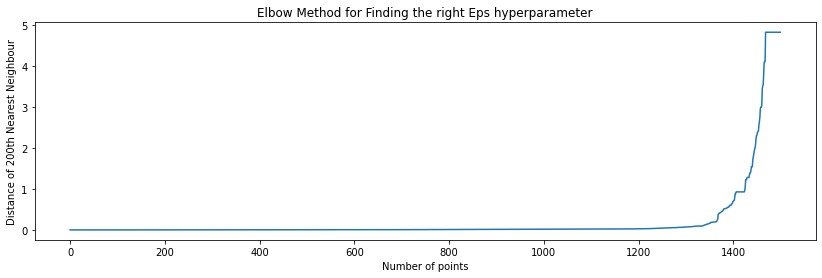

In [26]:
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [29]:
# Training DBSCAN :
model = DBSCAN(eps = 5, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors)
df_1['AVG-W2V Clus Label'] = model.labels_
df_1

,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label,AVG-W2V Clus Label
0,297256,"POSH MOBILE MICRO X, The Smallest Smartphone i...",Posh Mobile,49.99,5,Excellent for the price,0.0,Excellent for the price,Excellent price,Excellent price,excellent price,excel price,excel price,3,0
1,287045,OtterBox RealTree Defender Case Apple iPhone 5...,OtterBox,16.99,5,great product,0.0,great product,great product,great product,great product,great product,great product,2,0
2,158385,BLU Tank II T193 Unlocked GSM Dual-SIM Cell Ph...,BLU,20.99,5,😃,0.0,😃,😃,😃,😃,😃,😃,1,0
3,318855,Samsung Galaxy J7 J700M 16GB Dual Sim LTE Unlo...,Samsung,227.14,5,Awesome phone. Midrange phone? - Not to me. lo...,0.0,Awesome phone. Midrange phone? - Not to me. lo...,Awesome phone. Midrange phone? - Not me. lol p...,Awesome phone. Midrange phone? - Not me. lol p...,awesome phone. midrange phone? - not me. lol p...,awesom phone. midrang phone? - not me. lol pri...,awesom phone. midrang phone? - not me. lol pri...,1,0
4,120796,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,4,the phone works well. size is great st 5.5 inc...,0.0,the phone works well. size is great st 5.5 inc...,phone works well. size great st 5.5 inches..th...,phone works well. size great st . inches..the ...,phone works well. size great st . inches..the ...,phone work well. size great st . inches..th so...,phone work well. size great st . inches..th so...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,89485,BlackBerry Bold 9900 GSM Factory Unlocked Phon...,BlackBerry,85.00,1,I was under the impression that this item was ...,0.0,I was under the impression that this item was ...,I impression item Blackberry Bold 9900 I order...,I impression item Blackberry Bold I ordered i...,i impression item blackberry bold i ordered it...,i impress item blackberri bold i order it. the...,i impress item blackberri bold i order it. the...,1,0
3996,254796,Motorola MOTO X 2nd Gen XT1096 16GB (Verizon a...,Motorola,239.99,2,Disappointed it was NOT the unlocked version a...,0.0,Disappointed it was NOT the unlocked version a...,Disappointed NOT unlocked version advertised. ...,Disappointed NOT unlocked version advertised. ...,disappointed not unlocked version advertised. ...,disappoint not unlock version advertised. it v...,disappoint not unlock version advertised. it v...,1,0
3997,366544,Samsung Galaxy S6 G920F Gold Smartphone (5.1 Z...,Samsung,565.00,5,Bought this for someone they love the phone,0.0,Bought this for someone they love the phone,Bought someone love phone,Bought someone love phone,bought someone love phone,bought someon love phone,bought someon love phone,4,0
3998,285183,OtterBox Iphone 5/5S/SE Defender Case w/ Drop ...,OtterBox,6.99,4,Nice cheap phone case for holding credit cards...,0.0,Nice cheap phone case for holding credit cards...,Nice cheap phone case holding credit cards. Ca...,Nice cheap phone case holding credit cards. Ca...,nice cheap phone case holding credit cards. ca...,nice cheap phone case hold credit cards. can f...,nice cheap phone case hold credit cards. can f...,1,0


## Hieratchical Clustering

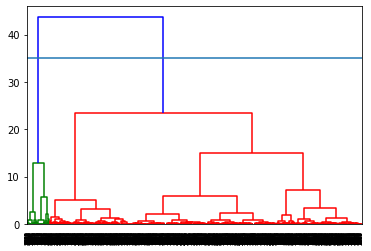

In [30]:
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=35)# cut at 30 to get 5 clusters

In [31]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
Agg=cluster.fit_predict(sent_vectors)

In [32]:
df_1['AVG-W2V Clus Label'] = cluster.labels_
df_1.head(2)
df_1.groupby(['AVG-W2V Clus Label'])['cleaned_text'].count()

AVG-W2V Clus Label
0    1012
1    1727
2     981
3     151
4     129
Name: cleaned_text, dtype: int64

In [33]:
for i in range(5):
    print("2 reviews of assigned to cluster ", i)
    print("-" * 70)
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][0]]['cleaned_text'])
    print('\n')
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][1]]['cleaned_text'])
    print('\n')
    print("_" * 70)

2 reviews of assigned to cluster  0
----------------------------------------------------------------------
awesom phone. midrang phone? - not me. lol price wise, worth


my dad love phone...


______________________________________________________________________
2 reviews of assigned to cluster  1
----------------------------------------------------------------------
phone work well. size great st . inches..th sound awful..u bare hear full power. return


i'm enjoy devi much. simpl unlock devise. i place at&t sim card start upload contact whatev el tie at&t locker. no glitch all.when origin purchas devise, i issue. it would delet incom text messag sever outgoing. it would also duplic incoming. it heat often send back button work. i wait cool abl close run apps. mess data usage. it' littl smaller i expected, i'm girl, work me. i could slip pocket problem. contact amazon good. ship anoth devi gave month return old one. work well. gave enough time transfer app imag time manner, rush pani

## In one paragraph, please compare K means, DBSCAN and Hierarchical clustering. 

K-means clustering is a popular clustering method that works well for large amounts of data. However, that is a generalized model that works well if performed for a larger number of iterations, and K-means is simple to understand with only a cluster of cluster of elements. K-means clustering will not work well when there is MISSING data or if there are some outliers in the dataset, while DBSCAN works well. Hierarchical clustering might not be as effective as k-means, but it works for any form of data and is used for a specific reason in which we need to find hierarchies in clusters. As seen in the example above of hierarchical clustering, clustering is done with the full text, and each cluster represents sentences with either a positive or negative meaning, but not both.